<a href="https://colab.research.google.com/github/vyshnavibethu/FMML_M2L3.ipynb/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 3: Manifold Learning Methods


```
Coordinator: Aswin Jose
```

---



Today, we will be focussing on non-linear dimensionality reduction methods or **Manifold learning** methods.

So a manifold is any space that is locally Euclidean. For example, the Earth is round but it looks flat to us. The Earth is a manifold: locally it is flat, but globally we know it is a sphere. Then, manifold learning performs dimensionality reduction by representing data as low-dimensional manifolds embedded in a higher-dimensional space.

We often suspect that high-dim may actually lie on or near a low-dim manifold (often much lower!) and it would be useful if we could reparametrize the data in terms of this manifold, yielding a low-dim embedding BUT - we typically don’t know the form of this manifold.

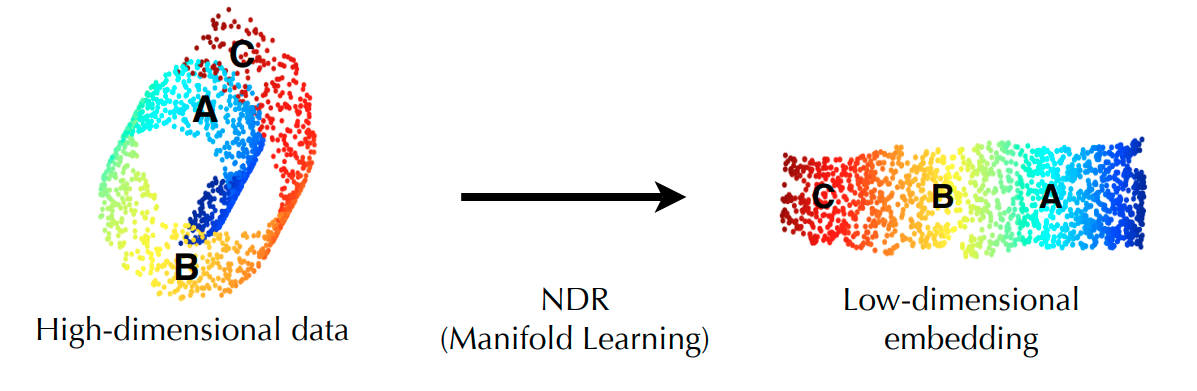

## ISOMAP

---

Isomap stands for **ISOmetric feature MAPping**. Isomap is a non-linear dimensionality reduction method based on the spectral theory which tries to preserve the geodesic distances in the lower dimension.

#### But what are Geodesic Distances?



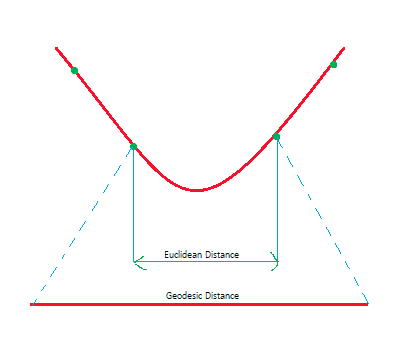

The next question should be:

*How can we compute geodesics without knowing the manifold?* .......
ANSWER: So we build an adjacency graph and approximate geodesic distances by shortest-paths through the graph.


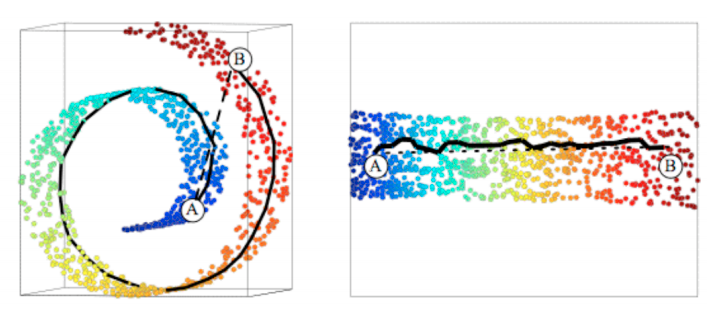

#### 3 steps for ISOMAP:

1. Build the adjacency graph over the points using a Neighbourhood selection method (let's say k nearest neighbours)
2. Compute approximate geodesics: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.
3. Take the top d eigenvectors of the Gram matrix.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

First let us simulate a dataset with the points lying on a manifold which we would want our Isomap to be able to capture.

We will be using the make_s_curve() function in the sklearn.datasets module to make the manifold using 1000 data points

In [2]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

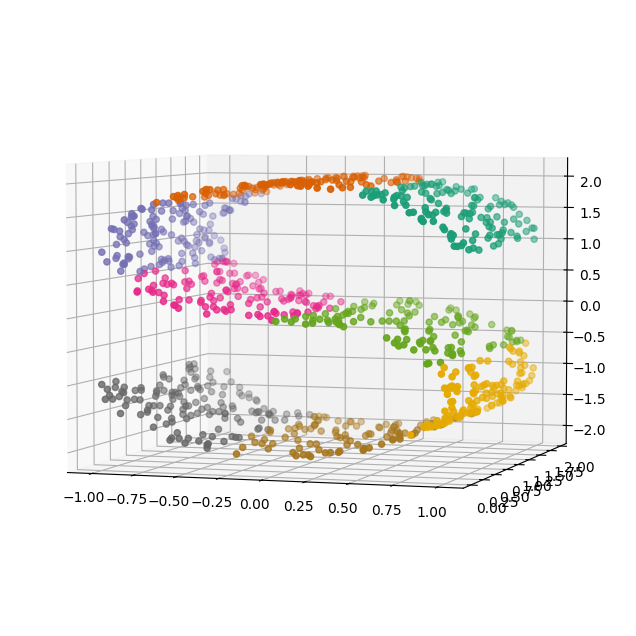

In [3]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

Note that all the points appear to be a lying on a curved 2d plane in this 3d dataset. Now we will be coding the Isomap algorithm to perform this manifold learning.


---

### Step 1a: First lets compute the distance matrix (pairwise Euclidean distances) from the data


In [4]:
def dist(a, b):
  '''Computes Euclidean distance between 2 points'''
  return np.sqrt(sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

# For N points in the dataset, this matrix should be of the dimension NxN.
# Our dataset had 1000 points, so we expect the dimensions of this matrix to be 1000x1000
print(distances.shape)

(1000, 1000)


### Step 1b: Let us keep only k nearest neighbors for each point in the distance matrix.

In [5]:
# Lets keep only the 10 nearest neighbors, others set to 0 (= unreachable)

n_neighbors = 10
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

In [6]:
neighbors.shape

(1000, 1000)



---

### Step 2: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.

We will be using the graph_shortest_path() function in the sklearn.utils.graph module.

The function takes an array of positive distances as the parameter. It then performs a shortest-path graph search on the graph and returns a matrix G (shape = N,N), where, G(i,j) gives the shortest distance from point i to point j along the graph.


In [ ]:
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)



---
### Step 3: Take the top d eigenvectors of the Gram matrix.


So let us first compute the gram matrix. If we have a matrix **graph**, then its Gram matrix is **graph**.T * **graph**





In [ ]:
gram = (graph ** 2)

We will now be computing the eigenvectors for this matrix, so lets first center the data points.

In [ ]:
n_samples = gram.shape[0]

# Mean for each row/column
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]

# NUMPY TRICKS: np.newaxis is used to increase the dimension of the existing array by one more dimension. So a (1000,) matrix becomes a (1000,1) matrix.

# Mean across all rows (entire matrix)
meanall = meanrows.sum() / n_samples

gram -= meanrows
gram -= meancols
gram += meanall

Computing eigenvectors

In [ ]:
# Using the np.linalg.eig() to compute eigenvectors and eigenvalues for the matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

# We will be sorting the eigenvalues and to preserve the corresponding eigenvectors, let us make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

# We want to reduce the dimensionality to **n_components** dimensions, therefore we will be first taking the top **n_components** eigenvectors (sorted in descending by eigenvalues)
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

# Transforming the matrix (dimensionality reduction)
n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T



---

## Plotting the resultant reduced_matrix


In [ ]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

##### As you can see the Isomap was able to capture the underlying 2d manifold in the S curve dataset.

Now of course there is an easier way to do this, using a predefined library Isomap by sklearn in the manifold module. It just requires you to enter the number of neighbours to be considered and the number of components the graph is to be reduced to.


In [ ]:
from sklearn.manifold import Isomap

In [ ]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()



---

### Now let us see if Isomap can learn the manifold representation in some more complex datasets

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

We loaded 766 images, each having 2914 pixels. Let us visualize our dataset before reducing the dimension

In [ ]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Our data is 2914 dimensional and our goal is to learn a low dimensional manifold from it. We first apply PCA (which we learn in Lab 2) and see if PCA is able to reduce it to lower dimensions while preserving much of the variance.

In [ ]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

So we can clearly observe that PCA requires more than 70 dimensions to be able to explain 90% of the variance, implying that PCA is failing to learn the underlying manifold effectively.

Let us now try to apply Isomap to this dataset and see if it is able to learn the representation effectively.

In [ ]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

We have reduced the dataset from 2914 dimensions to just 2 dimensions. Let us now visualize the result to be able to better understand the latent representation learnt by Isomap

In [ ]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

We get a very interesting result here. You can see that the Isomap was able to capture very interesting insights regarding the dataset.

If you observe along the x-axis, the images are positioned such that the orientation of the faces changes from left to right. Similarly, the darkness of the image increases in the positive direction of the y-axis.

This clearly indicates that Isomap was able to capture the underlying manifold very precisely in just 2 dimensions.

**You are motivated to play around with the number of neighbors and check if the following holds true across neighbourhoods!**



---


## Exercises!!

1. How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?
The number of neighbors in Isomap controls the connectivity of the graph constructed during dimensionality reduction, directly influencing the results:

Very Large Number of Neighbors:

The graph approximates a fully connected graph, where geodesic distances resemble straight-line distances in the ambient space. This causes Isomap to behave similarly to PCA, losing its ability to capture the true manifold's non-linear structure.
May lead to over-smoothing and a poor representation of the manifold.
Very Low Number of Neighbors:

The graph may become disconnected, meaning some points are unreachable from others. This results in incomplete or fragmented representations of the manifold.
Can lead to noisy embeddings or missing parts of the structure.
An optimal number of neighbors balances capturing local relationships while maintaining global connectivity.

2. When is the ISOMAP algorithm superior to PCA?
Isomap is superior to PCA when:

Non-linear Data Structures:
Isomap excels at capturing the global geometry of non-linear manifolds, unlike PCA, which assumes linear relationships between variables.
Example: Unwrapping a "Swiss roll" dataset.

Intrinsic Dimensionality Reduction:
If the data lies on a non-linear low-dimensional manifold within a high-dimensional space, Isomap can recover this low-dimensional structure.

PCA is better suited for linear datasets or when interpretability of principal components is crucial.

3. Search up another manifold learning methods other than ISOMAP? If there are any, whats the key difference ?


VN
You said:
1. Does averaging the validation accuracy across multiple splits give more consistent results?

2. Does it give more accurate estimate of test accuracy?
3. What is the effect of the number of iterations on the estimate? Do we get a better estimate with higher iterations?
4. Consider the results you got for the previous questions. Can we deal with a very small train dataset or validation dataset by increasing the iterations?
ChatGPT said:
ChatGPT
1. Does averaging the validation accuracy across multiple splits give more consistent results?
Yes, averaging the validation accuracy across multiple splits, as in k-fold cross-validation, gives more consistent results. It reduces the variability caused by the randomness of train-test splits. Each fold provides a different subset for training and validation, so the average accuracy captures the model's performance more reliably by accounting for variations across the dataset.

2. Does it give a more accurate estimate of test accuracy?
Yes, it generally gives a more accurate estimate of test accuracy. By averaging over multiple splits, we reduce the risk of overestimating or underestimating performance due to a particularly easy or difficult split. The averaged validation accuracy is a better approximation of the model's expected performance on unseen data, provided that the dataset is representative and the splits are done properly.

3. What is the effect of the number of iterations on the estimate? Do we get a better estimate with higher iterations?
Increasing the number of iterations (e.g., increasing
𝑘
k in k-fold cross-validation or running more random train-test splits) can improve the estimate's reliability. More iterations reduce variance in the performance estimate by sampling more configurations of training and validation data. However, the improvement diminishes beyond a certain point (law of diminishing returns), and computational cost also increases. Thus, there is a trade-off between computational efficiency and the precision of the estimate.

4. Can we deal with a very small training dataset or validation dataset by increasing the iterations?
Yes, increasing iterations can help mitigate the challenges of small datasets, but it has limitations:

Small Training Dataset: Repeated splitting can ensure that each data point contributes to both training and validation, but the small size limits the model's ability to learn meaningful patterns, especially for complex models. Data augmentation or synthetic data generation might also be necessary.

Small Validation Dataset: With a small validation dataset, averaging across multiple splits provides a more stable estimate of performance by reducing variability from small sample sizes. However, it still may not capture the full performance distribution.

For very small datasets, strategies like leave-one-out cross-validation (LOOCV) or bootstrapping can maximize data usage and provide better estimates, though they come with higher computational costs.

In general, while increasing iterations improves reliability, it cannot completely overcome the limitations of small datasets, as the quality and representativeness of the data itself are critical factors.






You said:
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?
ChatGPT said:
ChatGPT
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
The optimal values for angle and shear constraints depend on the specific dataset and the nature of the task. Typical ranges are:

Angle Constraint:
1
0
∘
10
∘
  to
3
0
∘
30
∘
  for rotation. Beyond
3
0
∘
30
∘
 , the augmented images might become unrealistic, especially for tasks sensitive to spatial orientation.
Shear Constraint: Values in the range of 0.1 to 0.3 (for small shear distortions) work well. Larger values may distort the images excessively.
On average, using these augmentations can improve accuracy by 5% to 15% compared to not using augmentations. The exact improvement depends on the dataset size and complexity.

2. Can you increase the accuracy by increasing the number of augmentations from each sample?
Yes, increasing the number of augmentations per sample can improve accuracy, but only up to a point. This works because:

Augmentations increase the diversity of the training data, helping the model generalize better.
For small datasets, this is particularly helpful in reducing overfitting.
However, diminishing returns occur beyond a certain number of augmentations, as the model starts to see redundant or overly distorted images. Careful tuning of augmentation parameters is essential to avoid introducing noise that could hurt performance.

3. Try implementing a few augmentations of your own and experimenting with them.
Here are a few custom augmentations that can be implemented and experimented with:

CutMix: Overlay patches of one image onto another and adjust labels proportionally.
GridMask: Overlay grid-like masks on images to occlude random sections.
Channel Shuffle: Shuffle the RGB channels of the image.
Random Erasing: Randomly occlude parts of the image with a blank patch.
Color Jitter Variants: Alter brightness, contrast, saturation, and hue with custom parameter ranges.
Each of these augmentations introduces unique variations that can improve generalization. Combining them with existing techniques can yield better results.

4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?
Combining Augmentations:
Using combinations like random rotation, shear, horizontal/vertical flips, brightness adjustments, and CutMix often yields the best results. For instance:

Combine moderate angle and shear constraints with flips and brightness jitter.
Add noise or occlusion techniques like Random Erasing to simulate real-world variations.
Smallest Dataset for 50% Accuracy:
Using aggressive augmentation, you can significantly reduce the training dataset size while maintaining acceptable performance. For many tasks:

A training set size of 10-20% of the original data combined with strong augmentations can yield over 50% accuracy.
Leave-one-out cross-validation or stratified sampling ensures efficient data usage.
However, achieving the exact result depends on the specific dataset, model, and augmentation setup.






You said:
Experiment with different transformation matrices and check the accuracy
Will the same transform used for these two features also work for other features?
ChatGPT said:
ChatGPT
1. Experimenting with Different Transformation Matrices and Checking Accuracy
Transformation matrices, such as those for rotation, translation, scaling, shear, and perspective transformations, alter the input data to simulate variations. Experimenting with these matrices can reveal how robust the model is to such transformations. The process typically involves:

Creating Transformation Matrices: For example:

Rotation:
𝑅
=
[
cos
⁡
𝜃
−
sin
⁡
𝜃
0
sin
⁡
𝜃
cos
⁡
𝜃
0
0
0
1
]
R=
​
  
cosθ
sinθ
0
​
  
−sinθ
cosθ
0
​
  
0
0
1
​
  
​

Shear:
𝑆
=
[
1
𝑚
0
𝑛
1
0
0
0
1
]
S=
​
  
1
n
0
​
  
m
1
0
​
  
0
0
1
​
  
​

Scaling and Translation follow similarly.
Applying Transformations to the Dataset: Augment your training data with transformations.

Evaluating Accuracy: Train the model with transformed data and validate it on untouched data to measure how transformations impact generalization.

2. Will the Same Transform Used for These Two Features Work for Other Features?
The same transformations might not work equally well for all features. Here’s why:

Feature-Specific Sensitivity: Some features (e.g., geometric shapes, spatial layouts) are sensitive to specific transformations like rotation or shear. For example:

A rotation may preserve semantic information in natural images but distort text recognition tasks.
Scaling might work well for one feature but obscure another feature’s distinctive characteristics.
Feature Representation in the Dataset: If certain features are already robust to a specific transformation (e.g., natural variations in the dataset), additional transformation might not add value.

Task-Dependent Behavior: For tasks like object detection, transformations like translation or scaling could affect bounding box accuracy, requiring additional adjustments.

Key Considerations:
Experimentation is Essential: Test transformations feature by feature and measure their individual and combined impact on accuracy.

Combining Transformations: Sometimes, applying multiple transformations (e.g., rotation + scaling) can better simulate real-world conditions.

Dynamic Transformation Policies: Using a dynamic policy where transformations are applied probabilistically during training often generalizes better.

Use Feature-Specific Transformations: For instance:

Use affine transforms for geometric features.
Use color jitter or histogram equalization for color-based features.
By iterating on these experiments, you can identify which transformations best generalize across features while maximizing model accuracy.






You said:
Think about the maximum/minimum values for each body-type, which body-type is the "costliest" ?

2) Do you think maximum/minimum values are a clear indication of which body-type is costliest, or does the interpretation improve by also taking the interquartile range into consideration?

3) Do you think the body-style of a car can be a good predictor for its price?
ChatGPT said:
ChatGPT
1. Which body-type is the "costliest"?
To determine which body-type is the "costliest," analyze the maximum and minimum values of the price distribution for each body-type. For example:

Costliest body-type: The one with the highest maximum price (e.g., luxury sedans, sports cars, or SUVs).
Least expensive body-type: The one with the lowest minimum price (e.g., compact cars or hatchbacks).
Luxury or niche body-types (e.g., sports cars or high-end SUVs) often dominate the top price brackets due to their premium features, performance, and exclusivity.

2. Are maximum/minimum values clear indicators, or does interquartile range improve interpretation?
Maximum and minimum values alone may not be reliable indicators of which body-type is costliest due to potential outliers. Instead, consider the interquartile range (IQR) for a better understanding:

IQR advantage: It focuses on the middle 50% of the data, providing insights into typical price ranges while avoiding skewed data caused by outliers.
Use Case:
A body-type with a very high maximum price but a low IQR might have only a few exceptionally expensive models, while the majority are moderately priced.
A body-type with a high IQR indicates consistently expensive models, making it a better candidate for being considered "costliest."
Conclusion: Including the IQR alongside max/min values provides a more nuanced and accurate interpretation of the costliest body-type.
3. Can the body-style of a car be a good predictor of its price?
Yes, body-style can be a reasonable predictor of price, but with caveats:

Correlation:

Certain body-styles inherently command higher prices due to their intended market (e.g., luxury sedans, SUVs, and sports cars are often pricier than hatchbacks or compact cars).
However, the variability within a body-style can be significant, depending on brand, features, and market segment.
Complementary Features:

To improve prediction accuracy, body-style should be used in conjunction with other features such as brand, engine size, performance metrics, luxury features, and year of manufacture.
Categorical Nature:

Body-style is categorical, so a model would benefit from encoding it appropriately (e.g., one-hot encoding or embedding techniques for machine learning models).
Final Takeaway:
While body-style is a meaningful predictor, its predictive power improves significantly when combined with other car attributes.






You said:
How many components do you need to retain 90% of the variance in the data?
2. Find one other use case that makes use of PCA and summarize how it is applied to the problem domain.
ChatGPT said:
ChatGPT
1. How many components do you need to retain 90% of the variance in the data?
To determine the number of components required to retain 90% of the variance in the data when using Principal Component Analysis (PCA):

Compute Explained Variance:

Perform PCA on the dataset to obtain the explained variance ratio for each principal component.
The explained variance ratio indicates the proportion of total variance captured by each component.
Cumulative Sum:

Calculate the cumulative sum of the explained variance ratios.
Find the smallest number of components for which the cumulative sum exceeds or equals 90%.
For example: If the cumulative explained variance ratios are
[
40
%
,
70
%
,
85
%
,
92
%
]
[40%,70%,85%,92%]:

You would need 4 components to retain at least 90% of the variance.
2. Use Case: PCA in Face Recognition (Eigenfaces)
One notable use case of PCA is in face recognition systems, such as the Eigenfaces approach. Here's how PCA is applied:

Problem Domain:

Face recognition involves identifying individuals based on images of their faces. The challenge is to deal with high-dimensional image data while focusing on the key patterns that distinguish one face from another.
Application of PCA:

Dimensionality Reduction: PCA is used to transform high-dimensional face image data into a lower-dimensional space by capturing the most significant features (principal components) that explain the variance in the images.
Eigenfaces: The principal components (or eigenvectors) of the face image dataset are computed, which represent the "eigenfaces." These are essentially a set of characteristic features that make up a face.
Representation: Each face image can be represented as a weighted combination of these eigenfaces, significantly reducing the data's dimensionality.
Recognition: The reduced representation is used for tasks such as classification or matching faces against a database.
Benefits:

PCA reduces computational cost and noise in the data.
It focuses only on the most critical features for differentiation.
Limitations:

PCA assumes linearity and is sensitive to lighting conditions and pose variations in images.
By using PCA, face recognition systems can efficiently store, process, and classify face data while maintaining accuracy.






You said:
 How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?

2. When is the ISOMAP algorithm superior to PCA?

3. Search up another manifold learning methods other than ISOMAP? If there are any, whats the key difference ?

4. Suggest ways to deal with missing data in manifold learning.
ChatGPT said:
ChatGPT
1. How does the number of neighbors affect the Isomap algorithm?
The number of neighbors in Isomap controls the connectivity of the graph constructed during dimensionality reduction, directly influencing the results:

Very Large Number of Neighbors:

The graph approximates a fully connected graph, where geodesic distances resemble straight-line distances in the ambient space. This causes Isomap to behave similarly to PCA, losing its ability to capture the true manifold's non-linear structure.
May lead to over-smoothing and a poor representation of the manifold.
Very Low Number of Neighbors:

The graph may become disconnected, meaning some points are unreachable from others. This results in incomplete or fragmented representations of the manifold.
Can lead to noisy embeddings or missing parts of the structure.
An optimal number of neighbors balances capturing local relationships while maintaining global connectivity.

2. When is the Isomap algorithm superior to PCA?
Isomap is superior to PCA when:

Non-linear Data Structures:
Isomap excels at capturing the global geometry of non-linear manifolds, unlike PCA, which assumes linear relationships between variables.
Example: Unwrapping a "Swiss roll" dataset.

Intrinsic Dimensionality Reduction:
If the data lies on a non-linear low-dimensional manifold within a high-dimensional space, Isomap can recover this low-dimensional structure.

PCA is better suited for linear datasets or when interpretability of principal components is crucial.

3. Other Manifold Learning Methods and Key Differences


4. Suggest ways to deal with missing data in manifold learning.
Data Imputation:

Fill missing values using statistical methods (mean, median, mode) or advanced techniques like k-nearest neighbors (KNN) imputation or regression-based methods.
Works well when missingness is not extensive and can preserve the manifold's structure.
Manifold-Specific Techniques:

Algorithms like Isomap can be modified to handle missing data by estimating geodesic distances based only on available data points.
Alternatively, iterative manifold learning approaches can refine the representation while imputing missing data.
Projection-Based Methods:

Use PCA or other dimensionality reduction methods as a preprocessing step to fill missing data by projecting it onto the learned subspace.
Excluding Points with Missing Data:

If missing data is sparse and non-essential, remove affected data points.
Be cautious, as this can reduce data representativeness.
Advanced Techniques:

Employ machine learning models such as neural networks or Gaussian processes to reconstruct missing data.
Use matrix completion techniques to estimate missing values based on known entries.
Each method should be chosen based on the extent of missing data and its impact on the manifold structure.









---

## Conclusion:
In practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

1) In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.

2) In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.

3) The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.

4) In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.

5) In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.

6) In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).

Therefore with all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.




---


### Some interesting references:

1) https://axon.cs.byu.edu/Dan/678/miscellaneous/Manifold.example.pdf

2) http://vision.cse.psu.edu/seminars/talks/PRML/David_NDR_lecture.pdf


---

